In [198]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import warnings                                  
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from itertools import product                   
from sklearn.model_selection import cross_val_score
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.optimize import minimize         
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from xgboost import XGBRegressor 
plt.rcParams['figure.figsize'] = [16, 9]

In [199]:
warnings.filterwarnings('ignore')

In [204]:
train = pd.read_csv('./ts_train.csv')
test = pd.read_csv('./ts_test.csv')
train.Temp = train.Temp.apply(lambda x: np.around(x))
test.Temp = test.Temp.apply(lambda x: np.around(x))
D = 30

In [201]:
features = train[['tsID','Temp', 'Saturday', 'Sunday', 'ACTUAL']]
features_test = test[['tsID','Temp', 'Saturday', 'Sunday']]
train_f = pd.get_dummies(features)
test_f = pd.get_dummies(features_test)

In [157]:
def mape(y, t): 
    return np.mean(np.abs((y - t) / y)) * 100

def select_ts(index):
    return (train[train_f.tsID == index].copy(),
            test[test_f.tsID == index].copy())

In [158]:
def prepare(data):
    train_matrix = []
    test_vector = []
    data  = data.ACTUAL.values
    for i in range(D, len(data)):
        train_matrix.append(data[i-D:i])
        test_vector.append(data[i])
    return np.array(train_matrix), np.array(test_vector)

In [163]:
def main(train, test):
    
    y = train.ACTUAL
    X = train.dropna().drop(['tsID'], axis=1).drop(['ACTUAL'], axis=1)
    tst = test.dropna().drop(['tsID'], axis=1)
    
    scaler_train = StandardScaler()
    X_sc = scaler_train.fit_transform(X)
    scaler_test = StandardScaler()
    test_sc = scaler_test.fit_transform(tst)
    
    model = XGBRegressor()
    model.fit(X_sc, y)

    predict = model.predict(test_sc)
    print(predict.shape)
    df = pd.Series(predict, index = tst.ID)
    return df

In [164]:
test_all = None
for i in range(1, 23):
    if test_all is None: 
        print(i)
        test_all = main(*select_ts(i))
    else:
        print(i)
        test_all = test_all.append(main(*select_ts(i)))

1


ValueError: could not convert string to float: '01.01.2010'

In [72]:
helper = pd.read_csv("helper.csv")

In [73]:
helperv = np.array(helper.value)

In [74]:
overfit1 = helperv*0.89 + test_all*0.11

In [75]:
overfit1.to_csv("overfit1.csv")

In [76]:
train1, test1 = select_ts(1)

In [77]:
y = train1.dropna().ACTUAL
X = train1.dropna().drop(['Date'], axis=1).drop(['tsID'], axis=1).drop(['ACTUAL'], axis=1)
tst = test1.dropna().drop(['Date'], axis=1).drop(['tsID'], axis=1)

In [78]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [79]:
scaler_new = StandardScaler()
test = scaler_new.fit_transform(tst)

In [80]:
xgb = XGBRegressor()
xgb.fit(X_sc, y)

[02:05:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [81]:
test1.shape

(300, 6)

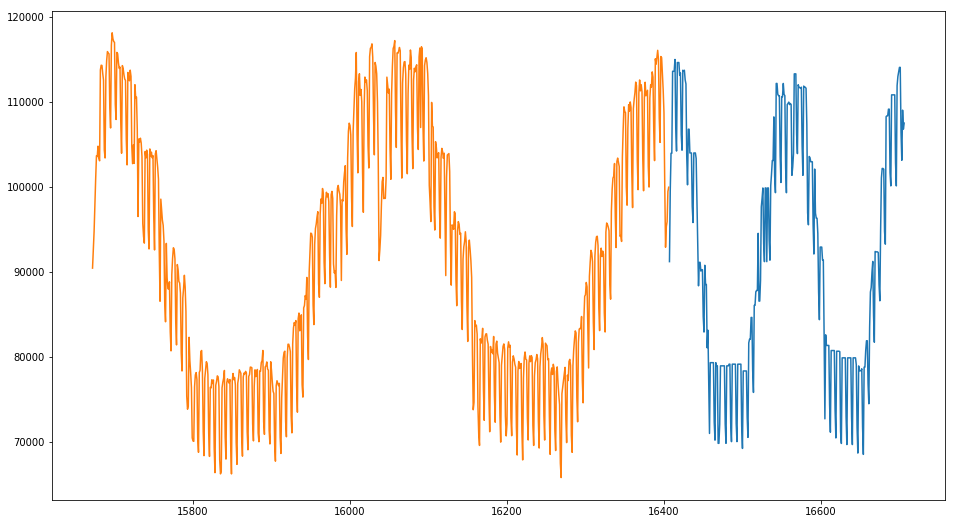

In [82]:
plt.plot(tst.ID, xgb.predict(test))
plt.plot(train1.ID, y)

In [83]:
import statsmodels.tsa.api as smt
from tqdm import tqdm_notebook as tqdm

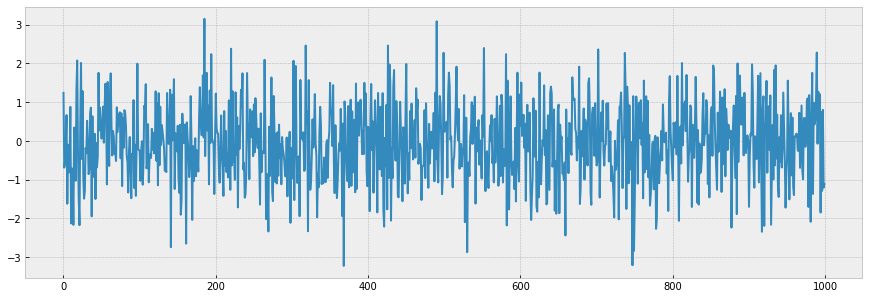

In [24]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

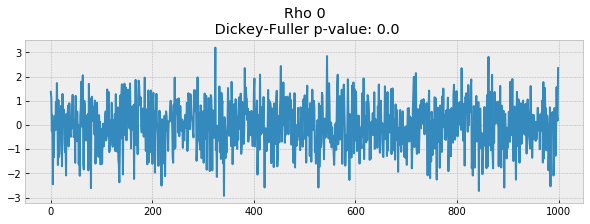

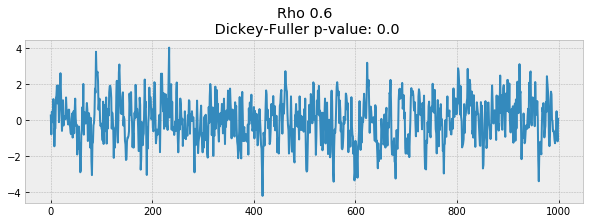

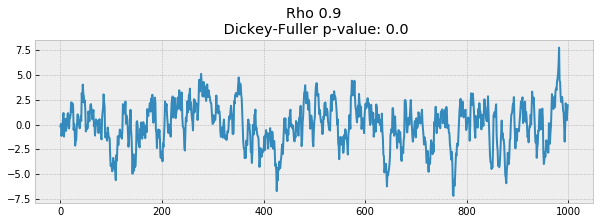

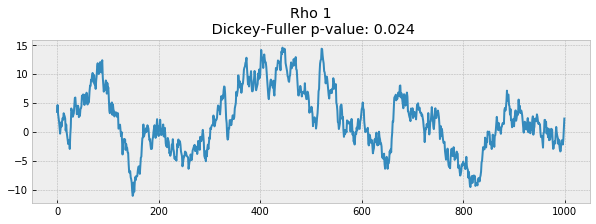

In [25]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

In [26]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

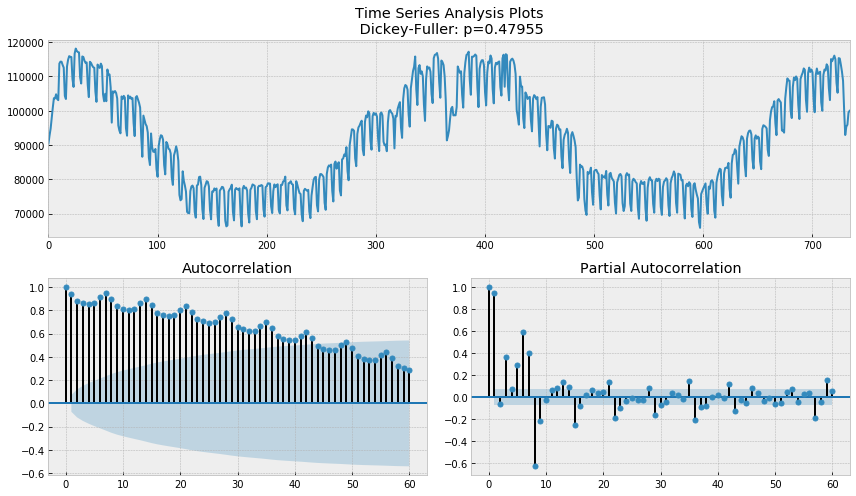

In [27]:
tsplot(y, lags=60)

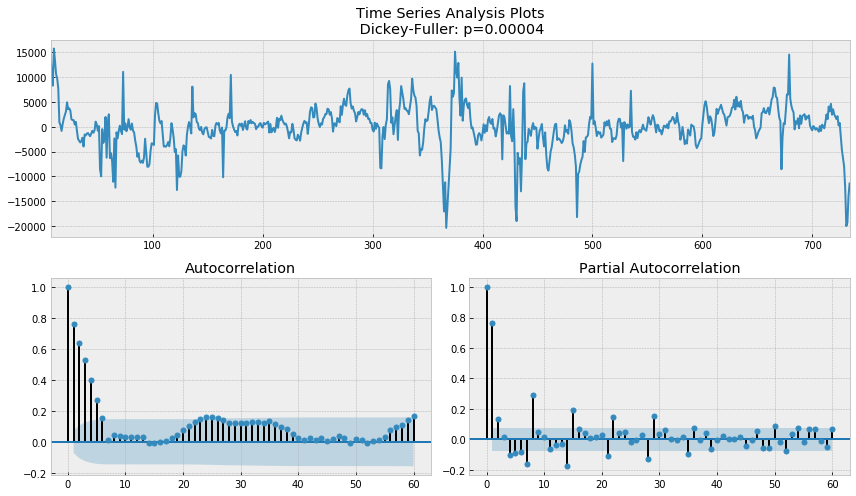

In [28]:
ts_diff = y - y.shift(7)
tsplot(ts_diff[7:], lags=60)

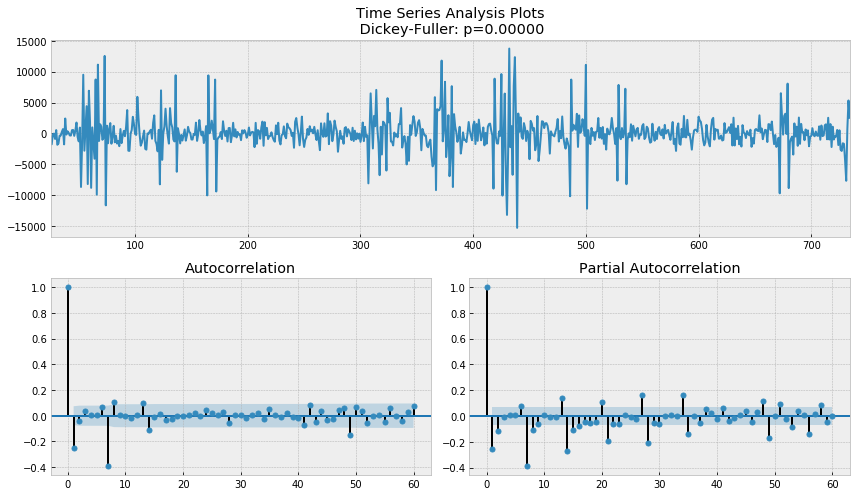

In [29]:
ts_diff = ts_diff - ts_diff.shift(1)
tsplot(ts_diff[24+1:], lags=60)

In [30]:
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [31]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table


In [32]:
result_table = optimizeSARIMA(parameters_list, d, D, s)
p, q, P, Q = result_table.parameters[0]

In [39]:
p, q, P, Q = result_table.parameters[0]
print(p,q,P,Q)

4 4 0 0


In [40]:
best_model=sm.tsa.statespace.SARIMAX(y, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

In [41]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             ACTUAL   No. Observations:                  735
Model:             SARIMAX(4, 1, 4)x(0, 1, 0, 24)   Log Likelihood               -6963.696
Date:                            Sat, 15 Jun 2019   AIC                          13945.392
Time:                                    21:08:00   BIC                          13986.479
Sample:                                         0   HQIC                         13961.264
                                            - 735                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5411      0.008    -63.854      0.000      -0.558      -0.524
ar.L2          0.2518      0.008   

In [42]:
yhat = best_model.forecast(300)

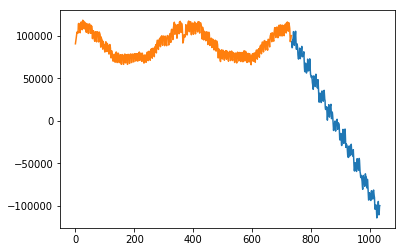

In [43]:
plt.plot(yhat)
plt.plot(y)